In [23]:
from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt
import warnings

def heats(T):
    #heats of reaction and heat capacity calculation from NIST
    t = T/1000

    #CH4
    A =	-0.703029
    B =	108.4773
    C =	-42.52157
    D =	5.862788
    E =	0.678565
    F =	-76.84376
    G =	158.7163
    H =	-74.87310

    dH_CH4 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CH4 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2O
    A =   30.09200
    B =   6.832514
    C =   6.793435
    D =  -2.534480
    E =   0.082139
    F =  -250.8810
    G =   223.3967
    H =  -241.8264

    dH_H2O = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2O = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO
    A =   25.56759
    B =   6.096130
    C =   4.054656
    D =  -2.671301
    E =   0.131021
    F =  -118.0089
    G =   227.3665
    H = -110.5271

    dH_CO = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO2
    A =   24.99735
    B =   55.18696
    C =  -33.69137
    D =   7.948387
    E =  -0.136638
    F =  -403.6075
    G =   228.2431
    H =  -393.5224

    dH_CO2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2
    A =  33.066178
    B = -11.363417
    C =  11.432816
    D = -2.772874
    E = -0.158558
    F = -9.980797
    G =  172.707974
    H =  0.0

    dH_H2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #Ar
    A =	20.78600
    B =	2.825911*10**-7
    C =	-1.464191*10**-7
    D =	1.092131*10**-8
    E =	-3.661371*10**-8
    F =	-6.197350
    G =	179.9990
    H =	0

    dH_Ar = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_Ar = A + B*t + C*t**2 + D*t**3 + E/(t**2) #J/mol K

    dHsmr = (3*dH_H2 + dH_CO - dH_CH4 - dH_H2O + 206.1)*10**3 #J/mol
    dHwgs = (dH_H2 + dH_CO2 - dH_CO - dH_H2O - 41.15)*10**3 #J/mol
    # print(dHsmr)
    # print(dHwgs)
    # print([Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2])
    return dHsmr, dHwgs, [Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2, Cp_Ar], [dH_CH4, dH_H2O, dH_CO, dH_CO2, dH_H2, dH_Ar]

In [24]:
#reactor constants
L = 0.0609 #m
R_inner = 0.00225 #m outside diameter of inner tube
R_outer = 0.0035 #m inside diameter of outer tube
Rin_outer = 0.003154/2 #m inner radius of inner tube

A = np.pi * ((R_outer)**2-(R_inner)**2) #m^2 AXIAL AREA (GAS FLOW)
V = A*L #m^3
Peri = 2*np.pi*R_outer
S = Peri*L #m^2 RADIAL AREA (HEAT FLUX AND REACTION)

Ain = np.pi * (Rin_outer)**2
Vin = Ain*L
Perimin = 2*np.pi*R_inner
Sinner = Perimin*L

#gas flow constants WHEN CHANGING THE TEMPERATURE YOU NEED TO ADJUST THE INITIAL GUESS -- USING ODEINT MIGHT BE FOR BETTER CONVERSION
Tinfeed = 450 #K
P = 3.15 #bar or atm
Rgas = 8.3144598 * 10**-5

sccm0 = np.array([16.16, 43.04, 0, 0, 9, 3.49])
mols0 = sccm0/22400 /60
#rate equation constants
Rreact = 8.314 #J / mol·K
#these are the constants we calculated!!!
Easmr = 69861/1000 #kJ/mol 165.740
Asmr = 16006
nsmr = 1.101
#these constants are taken from paper https://doi.org/10.1016/j.cattod.2006.07.022
Eawgs = 67.13 #kJ/mol
Awgs = 1.466*10**3

#OLD REACTION CONSTANTS
# Easmr = 165.740 #kJ/mol 165.740
# Asmr = 1.68*10**8
# Eawgs = 89.23 #kJ/mol
# Awgs = 9.90*10**3

Ku = 0.15 #0.5
I = 9 #curent in Amps
Fa = 96485 #faradays constant
h2Rem = 0

Tfurn = 1040 #K 1080
Uouter = 100 #120
Uinner = 104

#q_furn = 3400 #W/m2 K

MM = np.array([16.04, 18.01528, 28.01, 44.009, 2.016, 39.948])
m0 = np.dot(MM, mols0)
print(m0) #kg/s
print(np.sum(mols0))

x_num = 1000
dx = L/(x_num-1)
x_pts = np.linspace(0,L,x_num)

0.0008870138178571427
5.3340773809523796e-05


In [25]:
Tinmem = 1060 #K

Tfeed = np.concatenate((np.linspace(900,1000,int(x_num/20)), np.linspace(1000,1065,int(x_num*4/20)), 
                        np.full(int(x_num*11/20), 1065), np.linspace(1065,1035,int(x_num*2/20)), 
                        np.linspace(1035,1065,int(x_num*2/20))))[::-1]

In [26]:
boundarymem = np.concatenate((mols0, [Tinmem]))
#SHOULD UPDATE THE INITIAL GUESSES TO BE THE OUTCOMES OF THE LAST ONES I JUST NOW REALIZED
init_guess = np.zeros((7, x_num))
init_guess[0, :] = boundarymem[0]
init_guess[1, :] = boundarymem[1]
init_guess[2, :] = boundarymem[2]
init_guess[3, :] = boundarymem[3]
init_guess[4, :] = boundarymem[4]  
init_guess[5, :] = boundarymem[5]

index = 0
FurnTemps = np.linspace(800, 1100, 20)
sccmf = np.zeros((6,len(FurnTemps)))
modelTemps = np.zeros(len(FurnTemps))

for Tfurn in FurnTemps:
    for i in range(10):
        boundarymem = np.concatenate((mols0, [Tinmem]))
        # print(boundarymem)
        init_guess[6, :] = boundarymem[6]

        def odes(x, F):
            F[:6, :][F[:6, :] < 0] = 0
            y = F[:6]/np.sum(F[:6], axis = 0)
            T = F[6]
            Ctot = P/(Rgas * T)

            global vfinalmem
            v = np.sum(F[:6], axis = 0)/Ctot / A #m/sec
            vfinalmem = v
            Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
            Keqwgs = np.exp(4400/T - 4.036)

            rsmr = 2*np.pi*R_outer/A*Ku*Asmr*np.exp(-Easmr*1000/Rreact/T)*((y[0]**nsmr)*(y[1]**nsmr)-(P**(2*nsmr))*(y[2]**nsmr)*(y[4]**(3*nsmr))/(Keqsmr**nsmr))
            rwgs = 2*np.pi*R_outer/A*Ku*Awgs*np.exp(-Eawgs*1000/Rreact/T)*(y[1]*y[2]-y[3]*y[4]/Keqwgs)
            #rh2r = I/(2*Fa*L)
            rsmr[:int(x_num*0.02)] = 0
            rwgs[:int(x_num*0.02)] = 0

            dHsmr, dHwgs, Cps, _ = heats(T)
            Cpg = np.sum(y[:6, :]*Cps, axis=0)

            Fch4 = (-rsmr)*A
            Fh2o = (-rsmr - rwgs)*A
            Fco = (rsmr - rwgs)*A
            Fco2 = (rwgs)*A
            Fh2 = (3*rsmr + rwgs)*A # - h2Rem*rh2r
            Far = np.zeros(len(y[0]))
            Temp = (- A*(dHsmr*rsmr + dHwgs*rwgs) + Peri*Uouter*(-T[:] + Tfurn) +
                    Perimin*Uinner*(-T + Tfeed[:len(T)]))/(np.sum(F[:6], axis = 0)*Cpg)

            return np.vstack([Fch4, Fh2o, Fco, Fco2, Fh2, Far, Temp])

        def bcs(yleft, yright):
            return np.array(yleft-boundarymem)

        solnmem = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=x_num, tol = 0.01)

        Tmem = solnmem.y[6][::-1]

        boundaryfeed = np.concatenate((mols0, [Tinfeed]))
        # print(boundaryfeed)
        init_guess[6, :] = boundaryfeed[6]

        #CAN CHANGE THIS SO THAT IT ONLY DOES TEMPERATURE
        def odes(x, F):
            F[:6, :][F[:6, :] < 0] = 0
            y = F[:6]/np.sum(F[:6], axis = 0)
            T = F[6]
            Ctot = P/(Rgas * T)

            global vfinalfeed
            v = np.sum(F[:6], axis = 0)/Ctot / Ain #m/sec
            vfinalfeed = v

            _, _, Cps, _ = heats(T)
            Cpg = np.sum(y[:6, :]*Cps, axis=0)

            Fch4 = np.zeros(len(y[0]))
            Fh2o = np.zeros(len(y[0]))
            Fco = np.zeros(len(y[0]))
            Fco2 = np.zeros(len(y[0]))
            Fh2 = np.zeros(len(y[0]))
            Far = np.zeros(len(y[0]))
            Temp = Perimin*Uinner*(Tmem[:len(y[0])] - T)/(np.sum(F[:6,], axis = 0)*Cpg)

            return np.vstack([Fch4, Fh2o, Fco, Fco2, Fh2, Far, Temp])

        def bcs(yleft, yright):
            return np.array(yleft-boundaryfeed)

        solnfeed = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=x_num, tol = 0.0001)

        Tinmem = solnfeed.y[6,-1]
        Tfeed = solnfeed.y[6][::-1] 

    sccmf[:,index] = solnmem.y[:6,-1]*22400*60
    modelTemps[index] = solnfeed.y[6,int(x_num*5/6)]
    index += 1

print(modelTemps)

[ 792.72276931  806.61305287  820.43622345  834.2044276   847.94321392
  861.67667902  875.42779302  889.2183506   903.06876062  916.99782273
  931.02258743  945.15834994  959.41878457  973.81618883  988.36177671
 1003.06594101 1017.93839814 1033.0639272  1048.33322926 1063.80196819]


Text(0.5, 1.0, 'Temperature profile on membrane side')

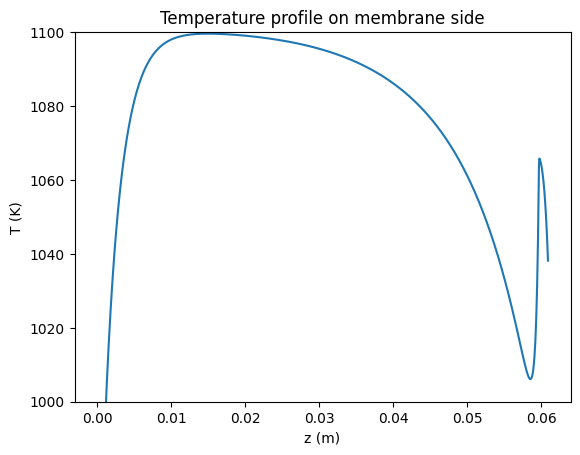

In [27]:
#membrane side temp
plt.plot(solnmem.x, solnmem.y[6][::-1])
plt.xlabel('z (m)')
plt.ylim(1000,1100)
plt.ylabel('T (K)')
plt.title('Temperature profile on membrane side')

Text(0.5, 1.0, 'Temperature profile on feed side')

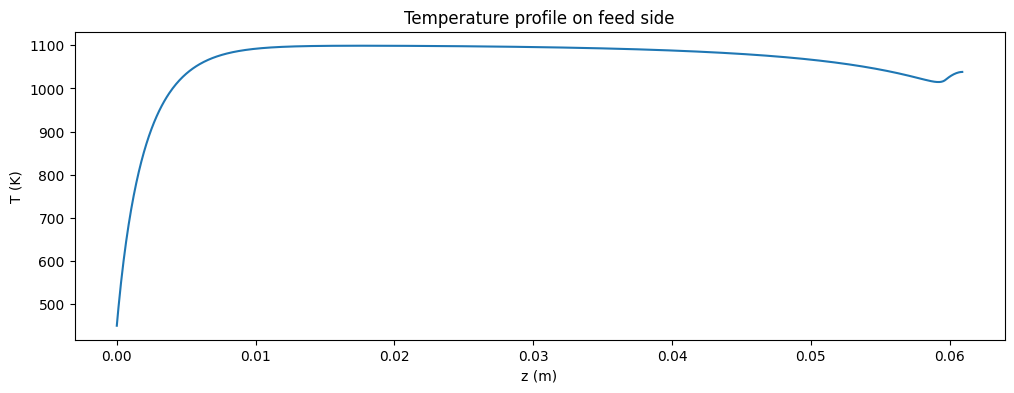

In [28]:
#feed side temp
plt.figure(figsize=(12, 4))
plt.plot(solnfeed.x, solnfeed.y[6], label = 'from membrane side calculation')
# plt.plot(solnfeed.x, Tfeedinitial, label = 'CFD estimate')
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Temperature profile on feed side')

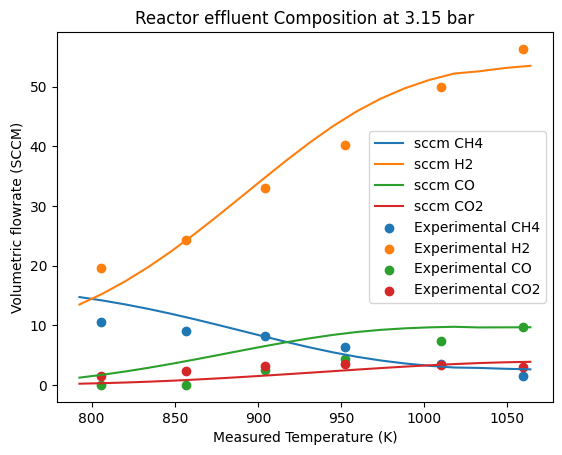

In [29]:
expTemp = np.array([532.8692303,583.5779216,631.2490162,679.4119108,737.2075,786.1913715])+273
expch4= np.array([10.58967786,9.100399715,8.183042916,6.427634432,3.492847043,1.427599783])
exph2 = np.array([19.61424661,24.35439391,33.08009652,40.18316061,49.97503291,56.3472753])
expco =np.array([0.0001429849477,0.001020061582,2.582607912,4.370178284,7.305258501,9.710402925])
expco2 =np.array([1.564520092,2.374852411,3.220787043,3.444686712,3.329101979,2.928459987])


#THIS IS NOT CORRECT BECAUSE HERE THE TEMPERATURE IS NOT THE MEASURED TEMPERATURE IT IS THE OUTSIDE SET TEMPERATURE!!!!!!!
plt.figure()
plt.plot(modelTemps, sccmf[0], label= 'sccm CH4')
plt.plot(modelTemps, sccmf[4], label= 'sccm H2')
plt.plot(modelTemps, sccmf[2], label= 'sccm CO')
plt.plot(modelTemps, sccmf[3], label= 'sccm CO2')
plt.scatter(expTemp, expch4, label = 'Experimental CH4')
plt.scatter(expTemp, exph2, label = 'Experimental H2')
plt.scatter(expTemp, expco, label = 'Experimental CO')
plt.scatter(expTemp, expco2, label = 'Experimental CO2')
plt.xlabel('Measured Temperature (K)')
plt.ylabel('Volumetric flowrate (SCCM)')
plt.title(f'Reactor effluent Composition at {P} bar')
plt.legend()